<a href="https://colab.research.google.com/github/rdkdaniel/Basics-of-ML-DL-Models/blob/main/Intro_Phishing_Detection_Using_Content_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Issue rendering from Github. Load from Colab**

This notebook is meant to be a gentle introduction to the task highlighted in the title above.

As such, a general overview of how images can help detect phishing (slight changes) is given with practical examples.





The notebook reviews:



*   Image comparison - what metric can be used? Mean squared error? Strctural SImilarity index?
*   Image condensation and compaction - We may need to go back to Fourier transforms?
*   Using SOM and Hierchacial clustering to identify features often manipulated or changed by intruders?
*   Bringing it all together.







# **Image Transformation**

**Using Fourier Transform:**

Wikipedia "In mathematics, a Fourier transform (FT) is a mathematical transform that decomposes a function (often a function of time, or a signal) into its constituent frequencies, such as the expression of a musical chord in terms of the volumes and frequencies of its constituent notes. The term Fourier transform refers to both the frequency domain representation and the mathematical operation that associates the frequency domain representation to a function of time."

## **Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist

## **Data - The Image**

In [ ]:
image = imread('/content/drive/MyDrive/Passport-sized-photograph-ruiru-daniel-kiguru.JPG')

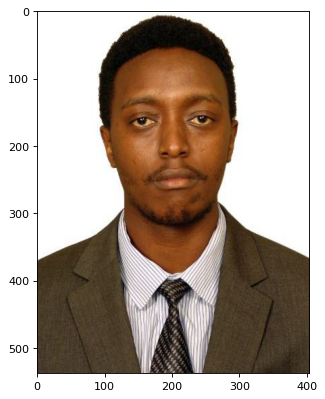

In [ ]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(image);

## **Convert image into Greyscale.**

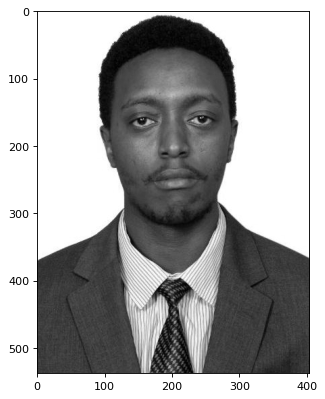

In [ ]:
image_grey = rgb2gray(image)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(image_grey, cmap='gray');

## **Using the fft function found in Skimage**

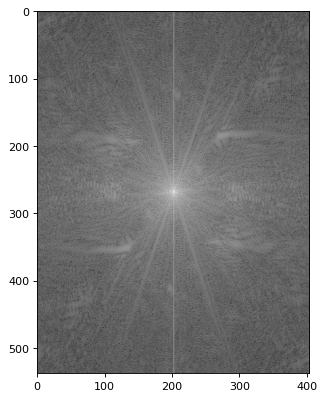

In [ ]:
image_grey_fourier = np.fft.fftshift(np.fft.fft2(image_grey))
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(image_grey_fourier)), cmap='gray');

The white vertical and horizontal lines refer to the sharp horizontal and vertical elements of the image. 



## **Masking one of these elements**

**Masking vertical element**

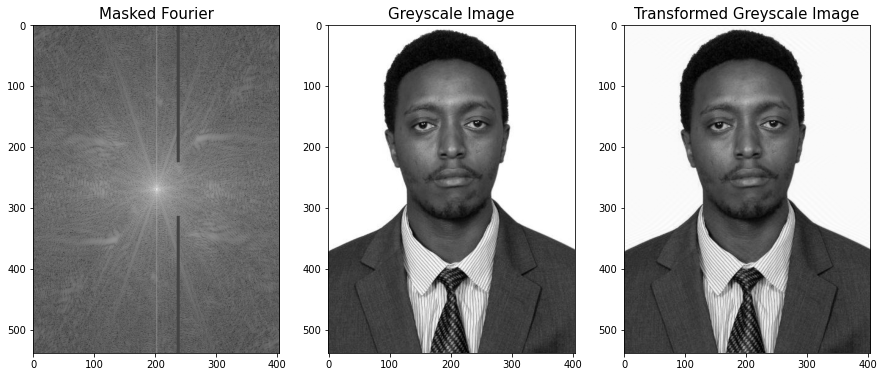

In [ ]:
def fourier_masker_ver(image, i):
    f_size = 15
    image_grey_fourier = np.fft.fftshift(np.fft.fft2(rgb2gray(image))) 
    image_grey_fourier[:225, 235:240] = i
    image_grey_fourier[-225:,235:240] = i   
    fig, ax = plt.subplots(1,3,figsize=(15,15))
    ax[0].imshow(np.log(abs(image_grey_fourier)), cmap='gray')
    ax[0].set_title('Masked Fourier', fontsize = f_size)
    ax[1].imshow(rgb2gray(image), cmap = 'gray')
    ax[1].set_title('Greyscale Image', fontsize = f_size);
    ax[2].imshow(abs(np.fft.ifft2(image_grey_fourier)), 
                      cmap='gray')
    ax[2].set_title('Transformed Greyscale Image', 
                     fontsize = f_size);
fourier_masker_ver(image, 1)

**Masking horizontal element**

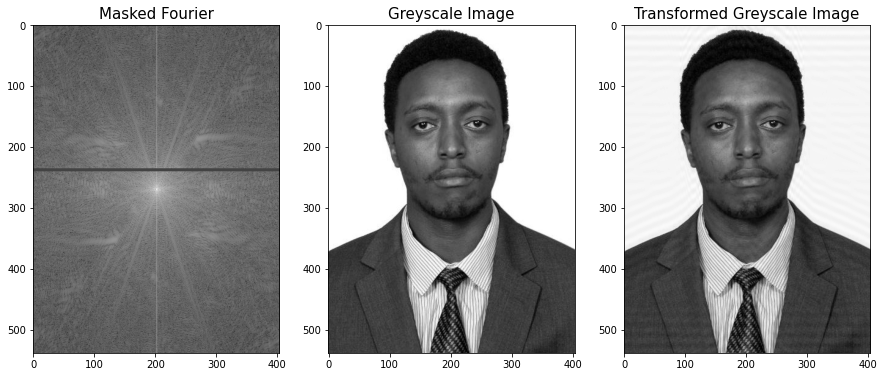

In [ ]:
def fourier_masker_hor(image, i):
    f_size = 15
    image_grey_fourier = np.fft.fftshift(np.fft.fft2(rgb2gray(image)))
    image_grey_fourier[235:240, :230] = i
    image_grey_fourier[235:240,-230:] = i    
    fig, ax = plt.subplots(1,3,figsize=(15,15))
    ax[0].imshow(np.log(abs(image_grey_fourier)), cmap='gray')
    ax[0].set_title('Masked Fourier', fontsize = f_size)
    ax[1].imshow(rgb2gray(image), cmap = 'gray')
    ax[1].set_title('Greyscale Image', fontsize = f_size);
    ax[2].imshow(abs(np.fft.ifft2(image_grey_fourier)), 
                     cmap='gray')
    ax[2].set_title('Transformed Greyscale Image', 
                     fontsize = f_size);
fourier_masker_hor(image, 1)

## **Different Degrees of Masking**

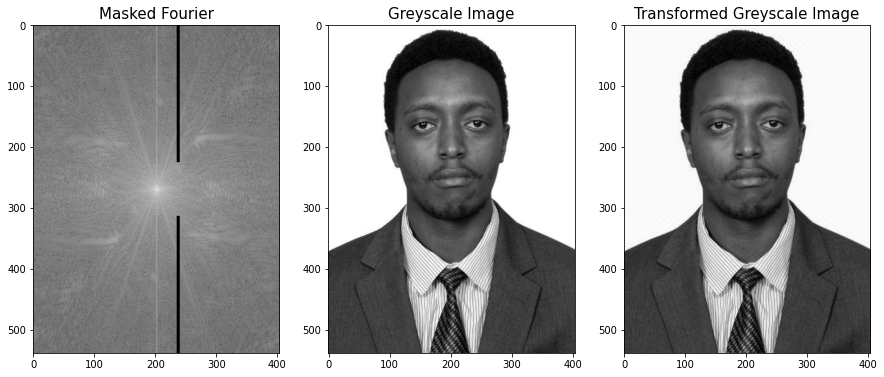

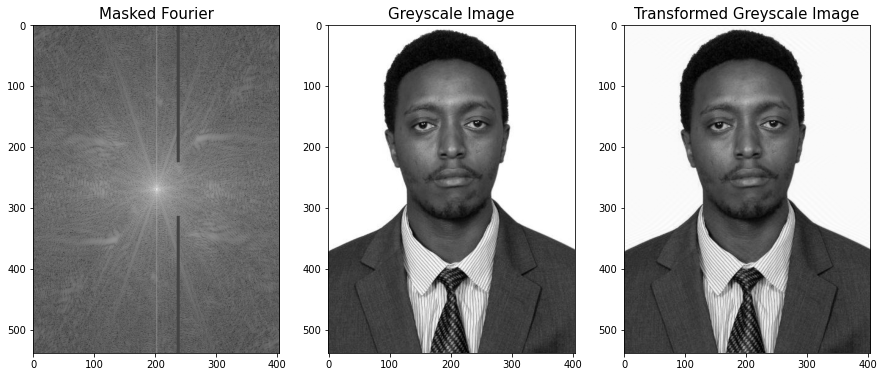

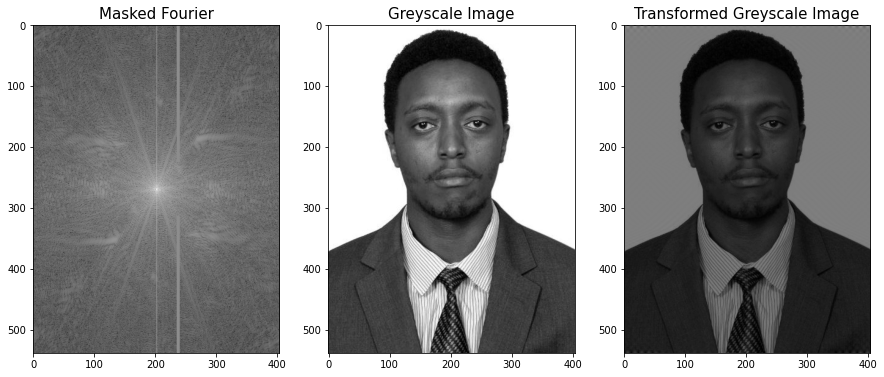

In [ ]:
def fourier_iterator(image, value_list):
    for i in value_list:
        fourier_masker_ver(image, i)
 
fourier_iterator(image, [0.001, 1, 100])

Decreasing the value has almost no effect on the original image, however increasing the value seems to darken original image. As there is practically no difference between the smaller value and 1, sticking to 1 for simplicity.

## **Fourier Transformation**

Enacting Fourier Transformation adjustment while retaining the colors of the original image.

In [ ]:
def fourier_transform_rgb(image):
    f_size = 25
    transformed_channels = []
    for i in range(3):
        rgb_fft = np.fft.fftshift(np.fft.fft2((image[:, :, i])))
        rgb_fft[:225, 235:237] = 1
        rgb_fft[-225:,235:237] = 1
        transformed_channels.append(abs(np.fft.ifft2(rgb_fft)))
    
    final_image = np.dstack([transformed_channels[0].astype(int), 
                             transformed_channels[1].astype(int), 
                             transformed_channels[2].astype(int)])
    
    fig, ax = plt.subplots(1, 2, figsize=(17,12)) 
    ax[0].imshow(image)
    ax[0].set_title('Original Image', 
                    fontsize = f_size)
    ax[0].set_axis_off()
    
    ax[1].imshow(final_image)
    ax[1].set_title('Transformed Image', 
                    fontsize = f_size)
    ax[1].set_axis_off()
    
    fig.tight_layout()

My indentation is wrong - there should be an output comparing original image with a FT one. Subtle changes should be observed.

# **Measuring Image Similarity**

A variety of similarity metrics are used.

These metrics are easy to implement (few lines of not one).

*   Mean Squared Error (MSE)
*   Root Mean Squared Error (RMSE)
*   Peak Signal-to-Noise Ratio (PSNR)
*   Structural Similarity Index (SSIM)
*   Universal Quality Image Index (UQI)
*   Multi-scale Structural Similarity Index (MS-SSIM)
*   Erreur Relative Globale Adimensionnelle de Synthèse (ERGAS)
*   Spatial Correlation Coefficient (SCC)
*   Relative Average Spectral Error (RASE)
*   Spectral Angle Mapper (SAM)
*   Visual Information Fidelity (VIF)




The sewar library can be used to implement all of these metrics and more.

## **Library**

In [ ]:
pip install sewar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10608 sha256=5d316d64155ba4da29fd0f346cc1101a750f40ab62e334da67c8f8da0db3c36c
  Stored in directory: /root/.cache/pip/wheels/d5/46/c1/7d4cdb3e32c09f3186ed699b12ac8aef0152932ab72f8fc9a5
Successfully built sewar


In [ ]:
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp

In [ ]:
print("MSE: ", mse(image_grey_fourier, image))
print("RMSE: ", rmse(image_grey_fourier, image))
print("PSNR: ", psnr(image_grey_fourier, image))
print("SSIM: ", ssim(image_grey_fourier, image))
print("UQI: ", uqi(image_grey_fourier, image))
print("MSSSIM: ", msssim(image_grey_fourier, image))
print("ERGAS: ", ergas(image_grey_fourier, image))
print("SCC: ", scc(image_grey_fourier, image))
print("RASE: ", rase(image_grey_fourier, image))
print("SAM: ", sam(image_grey_fourier, image))
print("VIF: ", vifp(image_grey_fourier, image))

AssertionError: ignored